# 09-sandcomp-seg.ipynb

This notebook adapts the segmentation workflow developed for IDOX to be used for the compressed F50 sand experiment 

# Import packages

In [40]:
# Set to False to use matplotlib.pyplot to view 2D images one at a time
use_napari = False
# Standard library imports
import math
from pathlib import Path
import sys
# Third-party imports
import matplotlib.pyplot as plt
if use_napari:
    import napari
import numpy as np
from skimage import color, exposure, filters, measure
# Local module imports
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
import segment
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load 3D data

In [41]:
# Load images as 3D array from a directory containing images
imgs = segment.load_images(
    Path(module_path) / r'data\SandComp4_18_22\NoComptiff',
    return_3d_array=True,
    convert_to_float=True,
    file_suffix='tiff'
)
print(f'Images loaded as 3D array: {imgs.shape}')

Images loaded as 3D array: (248, 1024, 343)


In [42]:
# Show images with napari
if use_napari:
    # Open napari viewer
    viewer = napari.Viewer()
    viewer.add_image(imgs)

## Crop Data

In [43]:
def crop_data(imgs, slice_lims=None, row_lims=None, col_lims=None):
    if slice_lims is None:
        slice_lims = [0, imgs.shape[0]]
    if row_lims is None:
        row_lims = [0, imgs.shape[1]]
    if col_lims is None:
        col_lims = [0, imgs.shape[2]]
    return imgs[
        slice_lims[0]:slice_lims[1], 
        row_lims[0]:row_lims[1], 
        col_lims[0]:col_lims[1]
    ]

In [44]:
imgs_cropped = crop_data(
    imgs, slice_lims=[75, 175], row_lims=[450, 600], col_lims=[100, 250]
)
imgs_cropped.shape

(100, 150, 150)

# Binarize data

In [45]:
def binarize_multiotsu(imgs, n_regions):
    imgs_binarized = np.zeros_like(imgs, dtype=np.float32)
    imgs_flat = imgs.flatten()
    imgs_binarized = np.zeros_like(imgs, dtype=np.float32)
    thresh_vals = filters.threshold_multiotsu(imgs_flat, n_regions)
    imgs_binarized[imgs > thresh_vals[-1]] = 1
    return imgs_binarized, thresh_vals

In [46]:
imgs_binarized, thresh_vals = binarize_multiotsu(imgs_cropped, 2)

# Segment Data

In [79]:
regions = []
for i in range(imgs_binarized.shape[0]):
    labels = measure.label(imgs_binarized[0, ...])
    regions += measure.regionprops(labels)
areas = [region.area for region in regions]
print(f'{areas[0]=}')
print(f'{areas[-1]=}')
print(f'{np.median(areas)=}')
median_slice_area = np.median(areas)
print(f'{int(median_slice_area // 50)=}')
print(f'{int(math.sqrt(median_slice_area) // 2)=}')
print('Radius of circle of equivalent area:')
print(f'{math.sqrt(median_slice_area / math.pi)}')
print('Floor of twice radius:')
print(f'{int(2 * math.sqrt(median_slice_area / math.pi))}')

areas[0]=236
areas[-1]=30
np.median(areas)=221.5
int(median_slice_area // 50)=4
int(math.sqrt(median_slice_area) // 2)=7
Radius of circle of equivalent area:
8.396763649746825
Floor of twice radius:
16


In [48]:
segment_dict = segment.watershed_segment(
    imgs_binarized, 
    min_peak_distance=int(math.sqrt(median_slice_area) // 2), 
    return_dict=True
)

In [49]:
segment_dict['cropped'] = imgs_cropped
def plot_segment_steps(
    segment_dict, 
    img_idx, 
    keys=['cropped', 'binarized', 'distance-map', 'colored-labels'],
    plot_maxima='distance-map', 
    fig_w=7,
):
    n_axes_h = 1
    n_axes_w = len(keys)
    img_w = segment_dict['cropped'].shape[2]
    img_h = segment_dict['cropped'].shape[1]
    title_buffer = .5
    fig_h = fig_w * (img_h / img_w) * (n_axes_h / n_axes_w) + title_buffer
    fig, axes = plt.subplots(
        n_axes_h, n_axes_w, dpi=300, figsize=(fig_w, fig_h), 
        constrained_layout=True, facecolor='white',
    )
    ax = axes.ravel()
    for i, key in enumerate(keys):
        if key == 'cropped':
            ax[i].imshow(
                segment_dict[key][img_idx, ...], interpolation='nearest',
                vmin=0, vmax=1
            )
        else:
            ax[i].imshow(
                segment_dict[key][img_idx, ...], interpolation='nearest'
            )
        ax[i].set_axis_off()
        ax[i].set_title(key)
        if plot_maxima == key:
            # Get x, y for all maxima
            x = segment_dict['maxima-points'][:, 2]
            y = segment_dict['maxima-points'][:, 1]
            # Find the maxima that fall on the current slice (img_idx)
            x_img_idx = x[segment_dict['maxima-points'][:, 0] == img_idx]
            y_img_idx = y[segment_dict['maxima-points'][:, 0] == img_idx]
            ax[i].scatter(x_img_idx, y_img_idx, color='red', s=2)
    return fig, axes

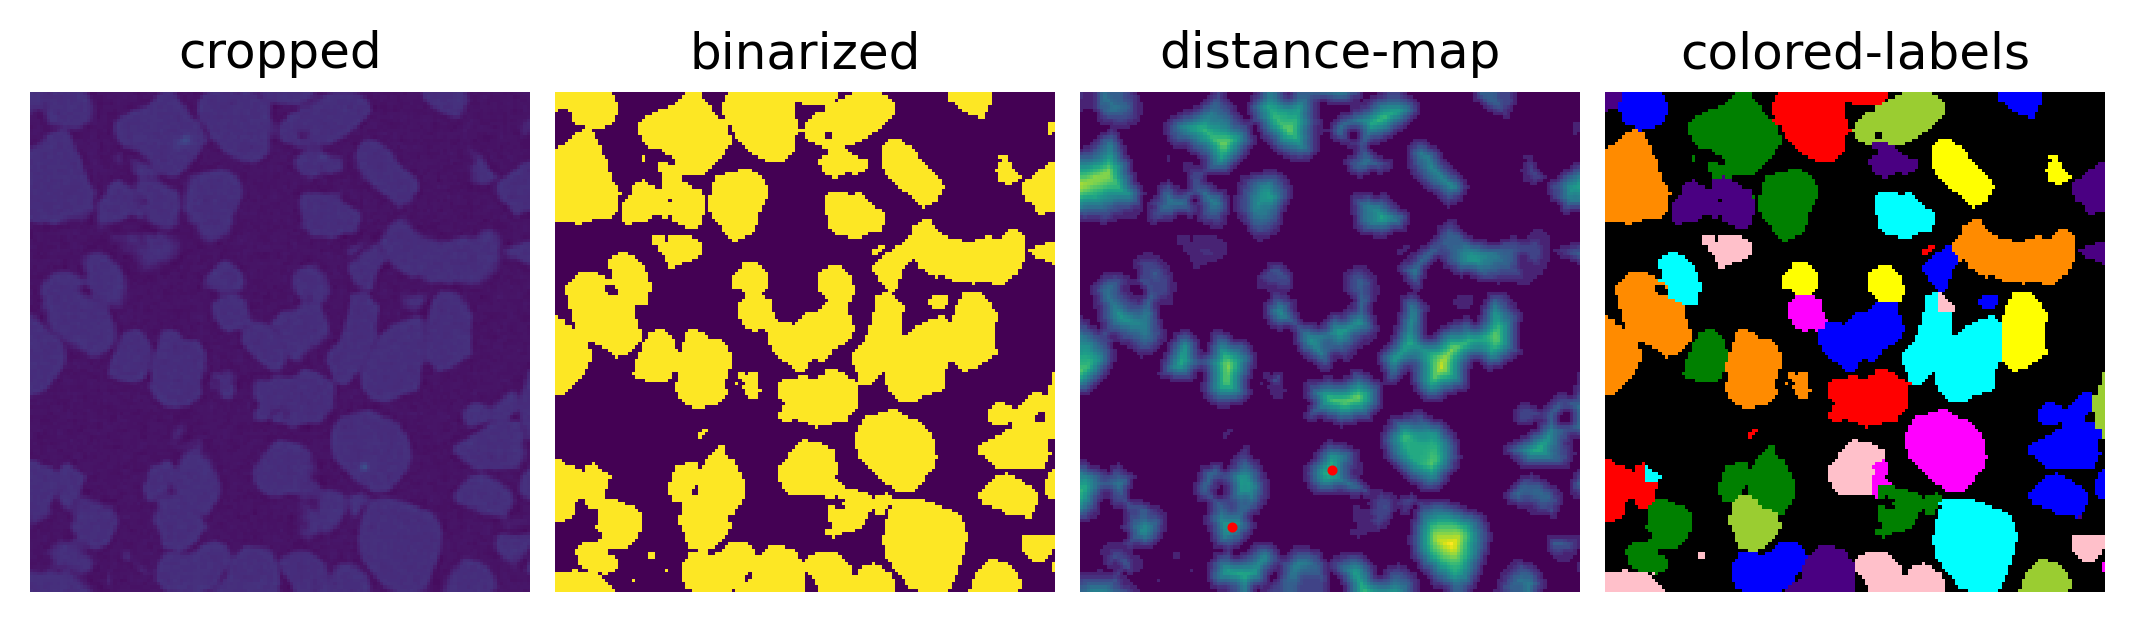

In [50]:
fig, axes = plot_segment_steps(segment_dict, 10)

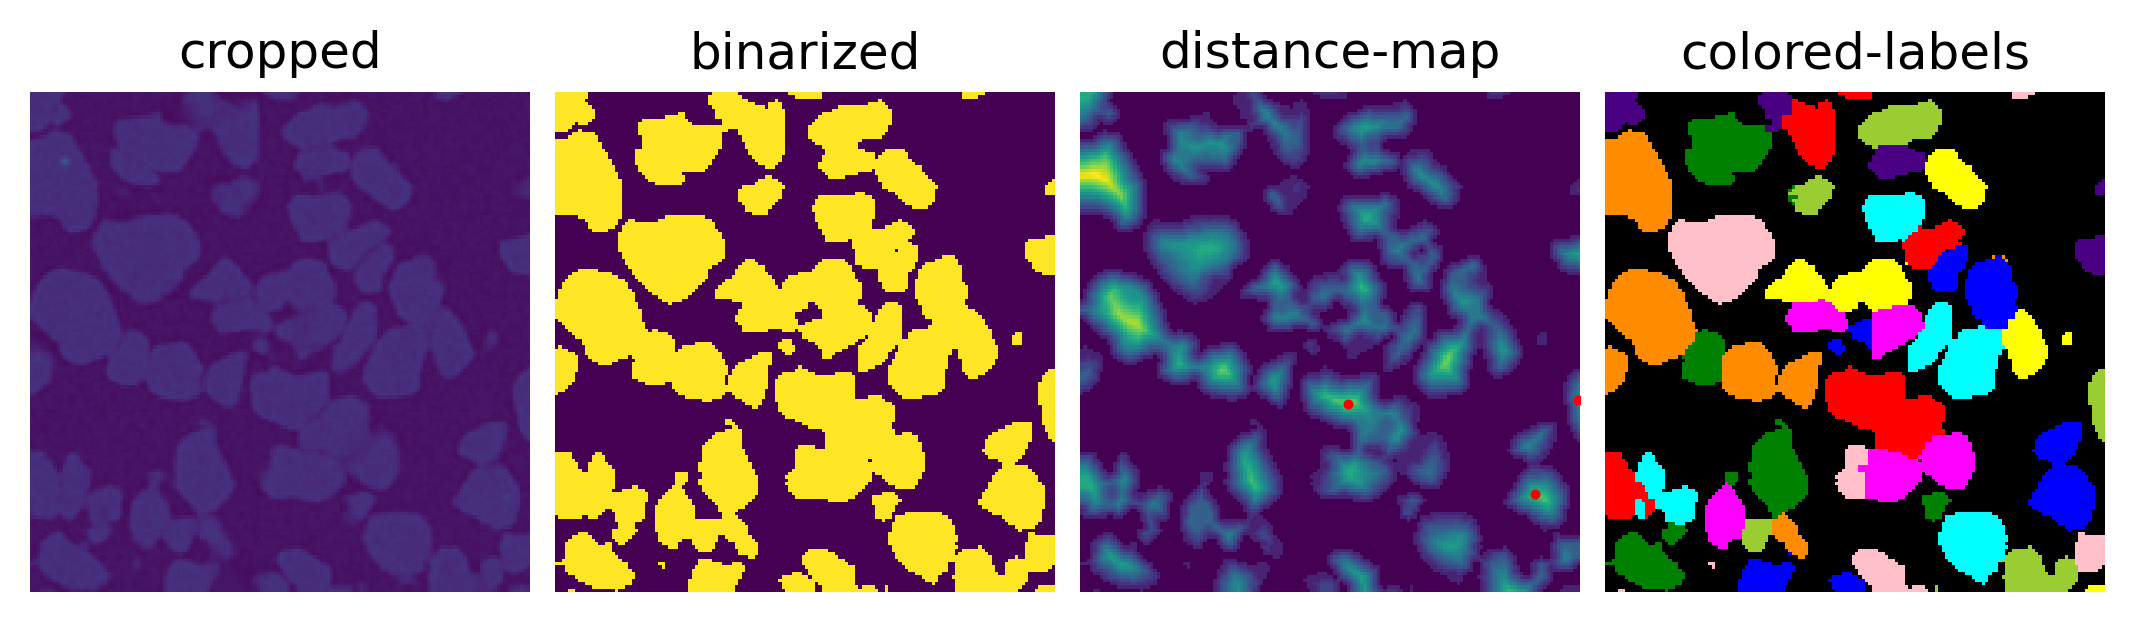

In [51]:
fig, axes = plot_segment_steps(segment_dict, 15)

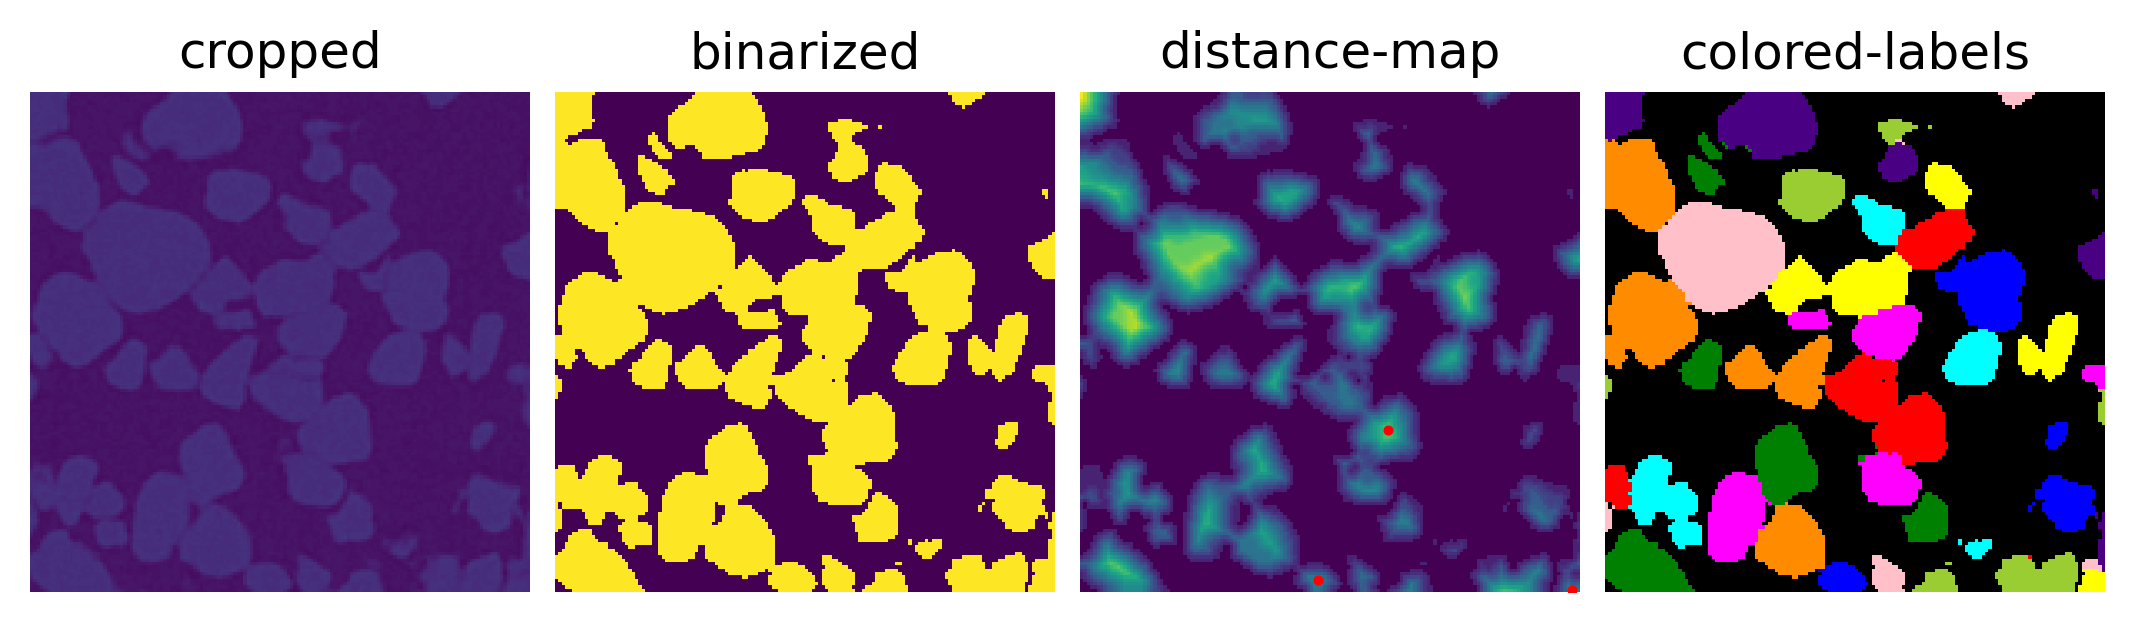

In [52]:
fig, axes = plot_segment_steps(segment_dict, 20)

In [53]:
# Show images with napari
if use_napari:
    viewer.add_image(imgs, translate=[-75, -450, -100])
    viewer.add_image(imgs_cropped)
    viewer.add_image(imgs_binarized)
    viewer.add_image(segment_dict['colored-labels'])

In [54]:
run_this_cell = False
if run_this_cell:
    for i in range(imgs_cropped.shape[0]):
        fig, axes = plot_segment_steps(segment_dict, i)
        fig.savefig(
            Path(
                module_path + '/results/SandComp04_18_22-NoComp'
                f'/segment-steps/segment-steps-{str(i).zfill(3)}.png'
            )
        )
        plt.close(fig)

# Plot images for 26-27 May 2022 presentation

In [55]:
def plot_img(img, title, fig_w=3, cmap='viridis', dpi=300, plot_points=None):
    nrows = 1
    ncols = 1
    img_w = img.shape[1]
    img_h = img.shape[0]
    fig_h = fig_w * (img_h / img_w) * (nrows / ncols)
    fig, ax = plt.subplots(
        figsize=(fig_w, fig_h), constrained_layout=True, dpi=dpi, 
        facecolor='white'
    )
    if cmap is None:
        ax.imshow(img, interpolation='nearest')
    else:
        ax.imshow(img, interpolation='nearest', cmap=cmap)
    ax.set_axis_off()
    ax.set_title(title)
    return fig, ax

def plot_hist(img, title, fig_w=3, cmap='viridis', dpi=300, axvline=None):
    nrows = 1
    ncols = 1
    img_w = img.shape[1]
    img_h = img.shape[0]
    fig_h = fig_w * (img_h / img_w) * (nrows / ncols)
    fig, ax = plt.subplots(
        figsize=(fig_w, fig_h), constrained_layout=True, dpi=dpi, 
        facecolor='white'
    )
    hist, hist_centers = exposure.histogram(img)
    ax.plot(hist_centers, hist)
    if axvline is not None:
        ax.axvline(axvline, color='red')
    # ax.set_axis_off()
    # ax.set_title(title)
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Number of pixels')
    return fig, ax

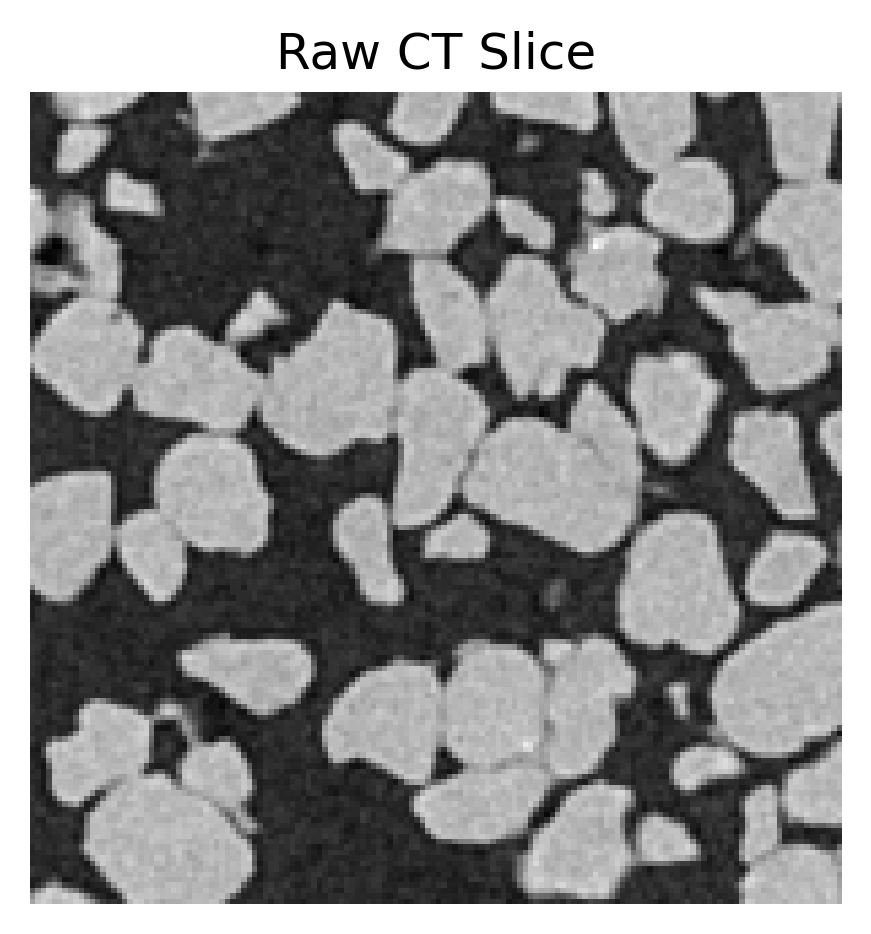

In [56]:
fig, ax = plot_img(imgs_cropped[55], 'Raw CT Slice', cmap='gray')
plt.show()

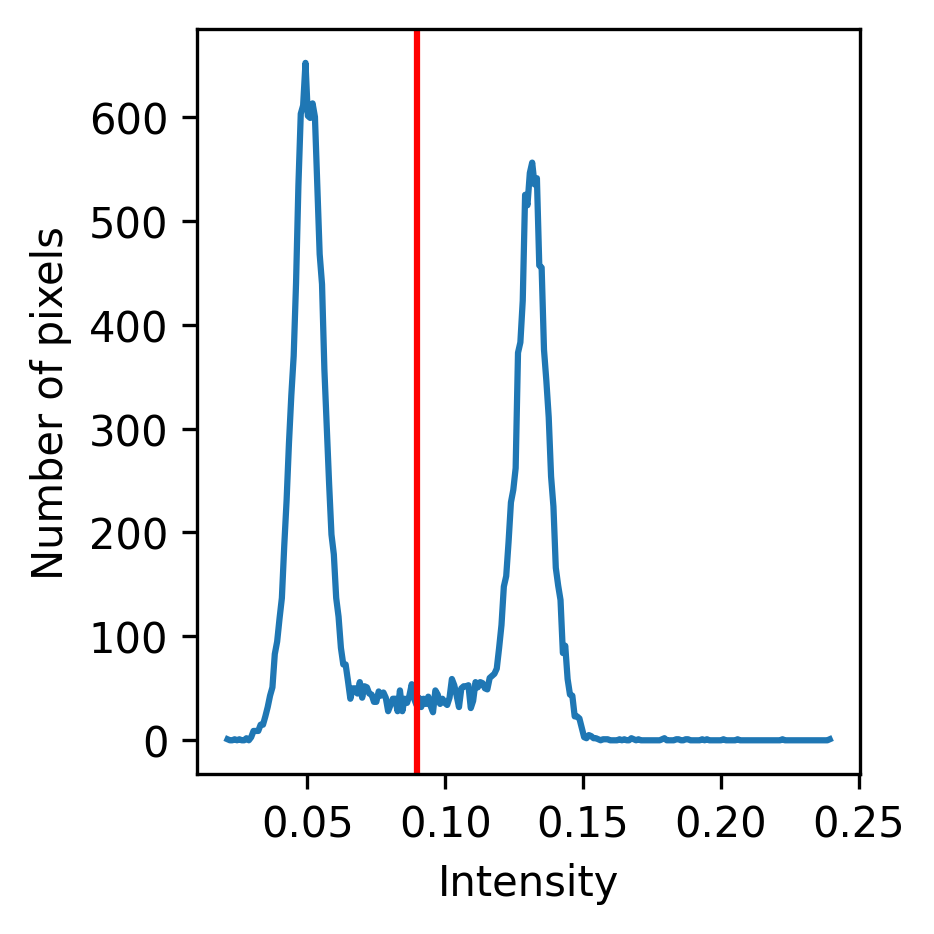

In [57]:
fig, ax = plot_hist(imgs_cropped[10], 'Histogram', axvline=thresh_vals[-1])
plt.show()

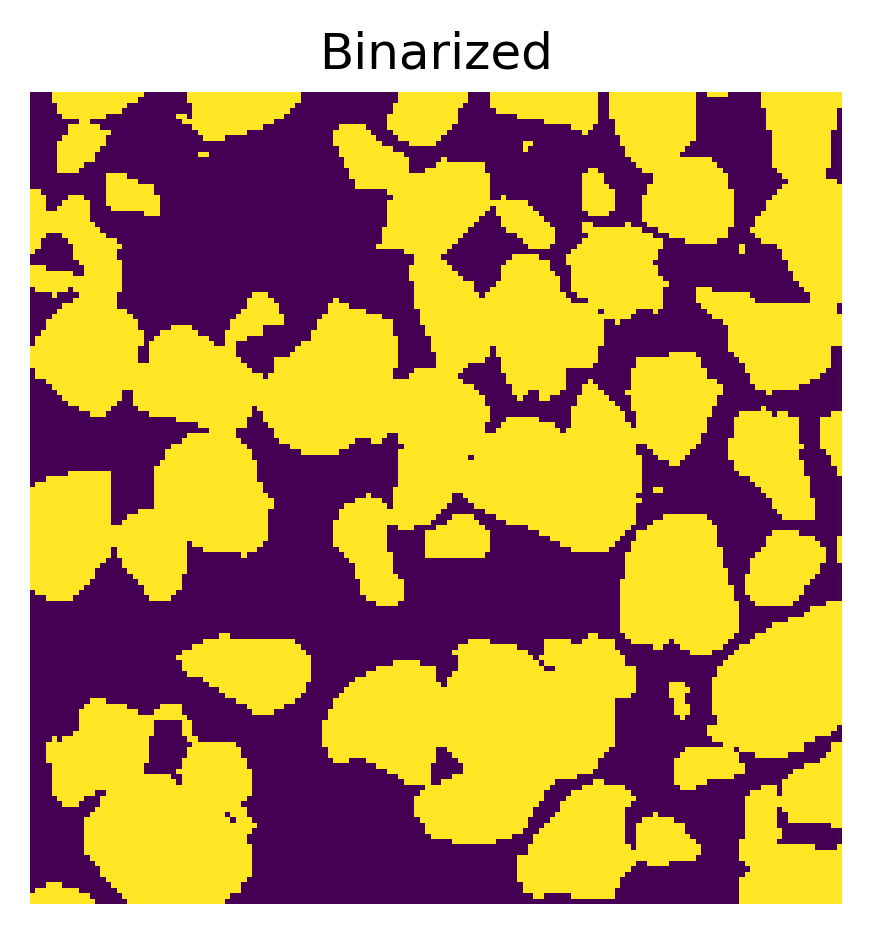

In [58]:
fig, ax = plot_img(imgs_binarized[55], 'Binarized', cmap='viridis')
plt.show()

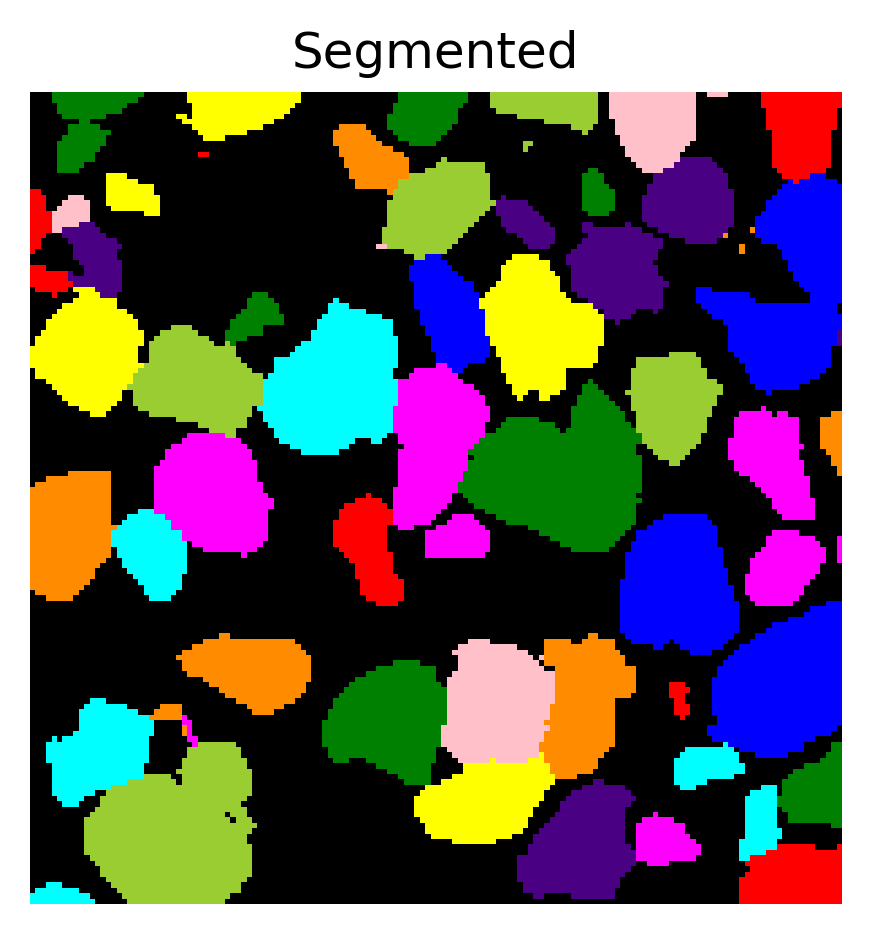

In [59]:
fig, ax = plot_img(segment_dict['colored-labels'][55], 'Segmented', cmap='gray')
plt.show()

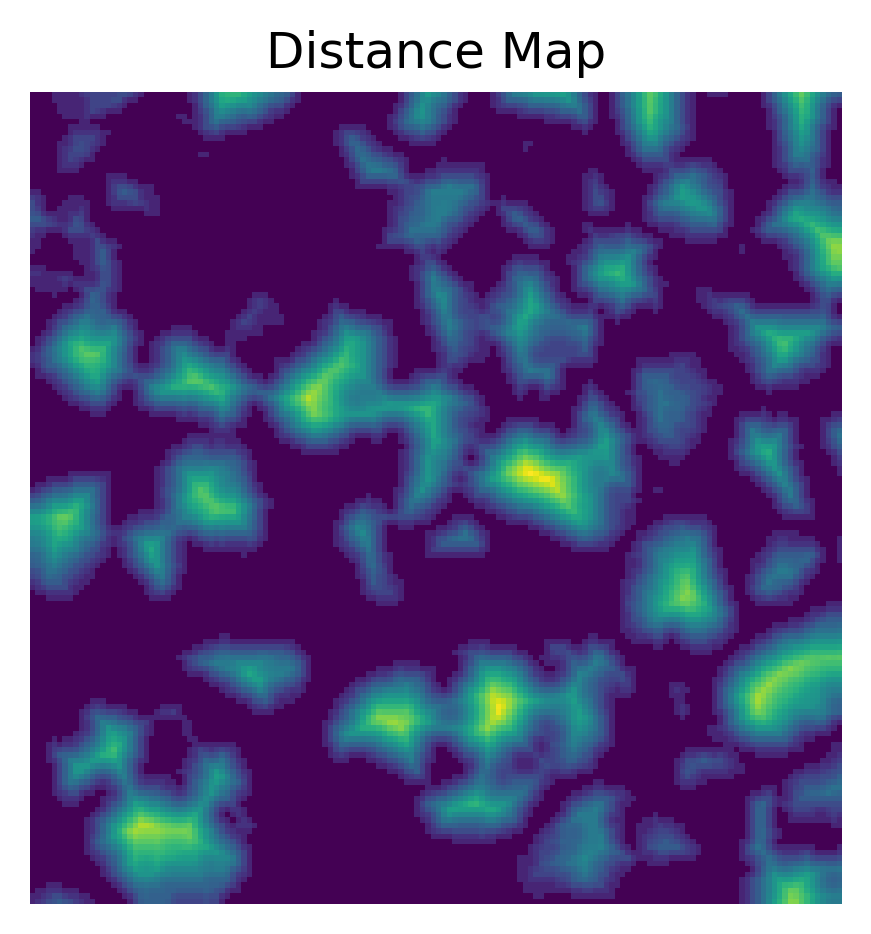

In [66]:
fig, ax = plot_img(segment_dict['distance-map'][55], 'Distance Map', cmap='viridis')
plt.show()